# Training DQN and PPO Agents on the LunarLander Environment: A Comparative Analysis

In [ ]:
!apt-get install swig
!pip install box2d-py
!apt-get update
!apt-get install cmake libopenmpi-dev zlib1g-dev
!pip install stable-baselines3[extra]
!pip install pyvirtualdisplay

In [ ]:
!pip install stable-baselines3[extra]

In [4]:
import os
os.makedirs("RL_Agent")

In [5]:
%%writefile RL_Agent/env_creator.py

from stable_baselines3.common.env_util import make_vec_env

def create_env(env_name: str, n_envs: int):
    """Creates environment for RL experiments.
    Takes in environment name and number of environments, and
    returns environment and evaluation environment."""

    env = make_vec_env(env_name, n_envs)
    eval_env = make_vec_env(env_name, n_envs)

    return env, eval_env


Writing RL_Agent/env_creator.py


In [6]:
env_name = "LunarLander-v2"
n_envs = 4

In [7]:
from RL_Agent import env_creator

env, eval_env = env_creator.create_env(env_name=env_name, n_envs=n_envs)

In [8]:
env, eval_env

(<stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv at 0x7e42e0a1e350>,
 <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv at 0x7e42e0a1e9b0>)

In [9]:
type(env), type(eval_env)

(stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv,
 stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv)

In [10]:
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.evaluation import evaluate_policy

In [ ]:
eval_callback = EvalCallback(eval_env, best_model_save_path='Eval_logs_best_DQN',
                                 log_path='Eval_logs_DQN', eval_freq=10,
                                 verbose=1)

In [11]:
%%writefile RL_Agent/evaluator.py

from stable_baselines3.common.callbacks import EvalCallback

def create_eval_callback(eval_env, best_model_save_path: str, log_path: str,
                         eval_freq: int, verbose: int):

    """Creates an evaluation callback for RL training."""
    eval_callback = EvalCallback(
        eval_env=eval_env,
        best_model_save_path=best_model_save_path,
        log_path=log_path,
        eval_freq=eval_freq,
        verbose=verbose
    )
    return eval_callback


Writing RL_Agent/evaluator.py


In [12]:
best_model_save_path = "best_model"
log_path = "logs"
eval_freq = 100
verbose = 1

In [13]:
from RL_Agent import evaluator

eval_callback = evaluator.create_eval_callback(eval_env = eval_env,
                                               best_model_save_path=best_model_save_path,
                                               log_path=log_path,
                                               eval_freq=eval_freq,
                                               verbose=verbose)

In [14]:
eval_callback

In [15]:
%%writefile RL_Agent/agent_creator.py

import torch
from stable_baselines3 import DQN
from stable_baselines3 import PPO

def create_agents(policy: str, env, learning_rate: float,
                     tensorboard_log: str, verbose: int, device: torch.device):

    """ Creates DQN and PPO agents """

    agent_dqn = DQN(policy, env, learning_rate=learning_rate,
                tensorboard_log=tensorboard_log, verbose=verbose, device=device)

    agent_ppo = PPO(policy, env, learning_rate=learning_rate,
                tensorboard_log=tensorboard_log, verbose=verbose, device=device)


    return agent_dqn, agent_ppo


Writing RL_Agent/agent_creator.py


In [16]:
import torch
policy = "MlpPolicy"
env = env
learning_rate = 0.0001
tensorboard_log = "logs_tensorboard"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [17]:
from RL_Agent import agent_creator

dqn_agent, ppo_agent = agent_creator.create_agents(policy=policy,
                            env=env,
                            learning_rate=learning_rate,
                            tensorboard_log=tensorboard_log,
                            device=device,
                            verbose=verbose)

Using cuda device
Using cuda device


In [18]:
dqn_agent, ppo_agent

(<stable_baselines3.dqn.dqn.DQN at 0x7e42e0a1d0f0>,
 <stable_baselines3.ppo.ppo.PPO at 0x7e418fd1ddb0>)

In [19]:
%%writefile RL_Agent/engine.py

def train_agent(agent, total_timesteps: int, callback, tb_log_name: str):

    """Train the agent with specified parameters."""

    agent.learn(total_timesteps=total_timesteps, callback=callback, tb_log_name=tb_log_name)

Writing RL_Agent/engine.py


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [22]:
tb_log_name = "runs"
callback = eval_callback
total_timesteps = 100_000

In [25]:
from RL_Agent import engine

# Train the DQN agent
engine.train_agent(agent=dqn_agent,
                   total_timesteps=total_timesteps,
                   callback=callback,
                   tb_log_name=tb_log_name)

Logging to logs_tensorboard/runs_3
Eval num_timesteps=400, episode_reward=-21.75 +/- 158.80
Episode length: 786.20 +/- 262.81
----------------------------------
| eval/               |          |
|    mean_ep_length   | 786      |
|    mean_reward      | -21.8    |
| rollout/            |          |
|    exploration_rate | 0.962    |
| time/               |          |
|    total_timesteps  | 400      |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.51     |
|    n_updates        | 6355     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 97.5     |
|    ep_rew_mean      | -133     |
|    exploration_rate | 0.956    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 61       |
|    time_elapsed     | 7        |
|    total_timesteps  | 468      |
| train/              |          |
|    learning_rate    | 0.0001   |

In [26]:
# Train the PPO agent
engine.train_agent(agent=ppo_agent,
                   total_timesteps=total_timesteps,
                   callback=callback,
                   tb_log_name=tb_log_name)

Logging to logs_tensorboard/runs_4
Eval num_timesteps=400, episode_reward=-248.22 +/- 166.99
Episode length: 64.20 +/- 11.57
---------------------------------
| eval/              |          |
|    mean_ep_length  | 64.2     |
|    mean_reward     | -248     |
| time/              |          |
|    total_timesteps | 400      |
---------------------------------
Eval num_timesteps=800, episode_reward=-190.70 +/- 130.87
Episode length: 62.80 +/- 10.46
---------------------------------
| eval/              |          |
|    mean_ep_length  | 62.8     |
|    mean_reward     | -191     |
| time/              |          |
|    total_timesteps | 800      |
---------------------------------
Eval num_timesteps=1200, episode_reward=-391.21 +/- 223.19
Episode length: 66.40 +/- 9.56
---------------------------------
| eval/              |          |
|    mean_ep_length  | 66.4     |
|    mean_reward     | -391     |
| time/              |          |
|    total_timesteps | 1200     |
---------------

# Evaluation

In [11]:
import numpy as np
import pandas as pd

In [3]:
logs_dqn = np.load('evaluations_dqn.npz', allow_pickle=True)
logs_ppo = np.load('evaluations_ppo.npz', allow_pickle=True)

In [4]:
reward_dqn = np.array(logs_dqn['results'])
reward_ppo = np.array(logs_ppo['results'])

In [6]:
reward_dqn_flat = reward_dqn.flatten()
timesteps_dqn = np.arange(len(reward_dqn_flat))
df_dqn = pd.DataFrame({'timesteps': timesteps_dqn, 'rewards': reward_dqn_flat})

In [7]:
reward_ppo_flat = reward_ppo.flatten()
timesteps_ppo = np.arange(len(reward_ppo_flat))
df_ppo = pd.DataFrame({'timesteps': timesteps_ppo, 'rewards': reward_ppo_flat})

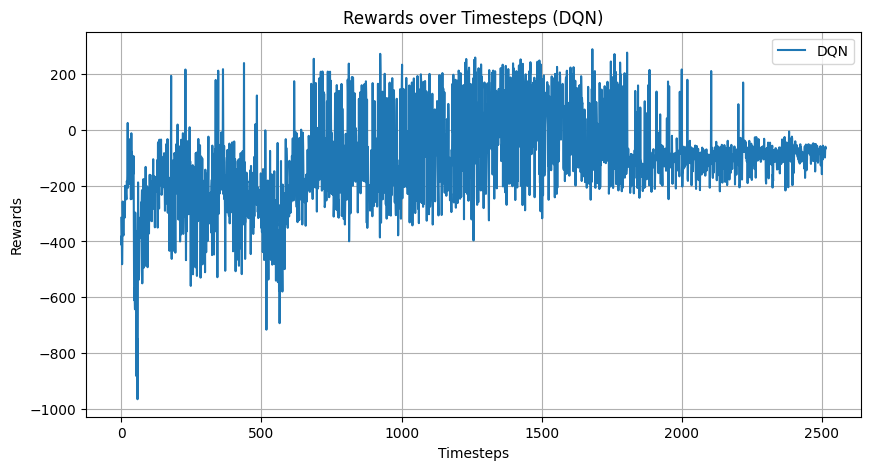

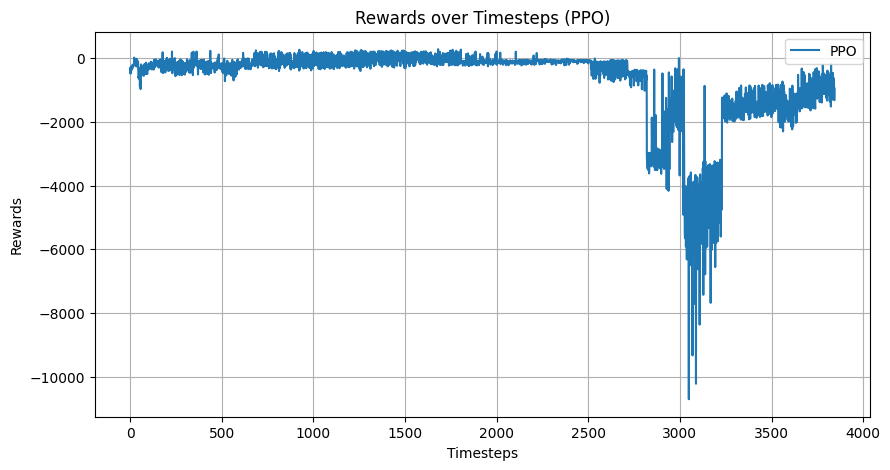

In [10]:
import matplotlib.pyplot as plt

# Create Matplotlib plot for DQN rewards
plt.figure(figsize=(10, 5))
plt.plot(df_dqn['timesteps'], df_dqn['rewards'], label='DQN')
plt.title('Rewards over Timesteps (DQN)')
plt.xlabel('Timesteps')
plt.ylabel('Rewards')
plt.legend()
plt.grid(True)

# Create Matplotlib plot for PPO rewards
plt.figure(figsize=(10, 5))
plt.plot(df_ppo['timesteps'], df_ppo['rewards'], label='PPO')
plt.title('Rewards over Timesteps (PPO)')
plt.xlabel('Timesteps')
plt.ylabel('Rewards')
plt.legend()
plt.grid(True)

plt.show()
